## Get API key

In [3]:
import os
import getpass

os.environ["Cohere_API_KEY"] = getpass.getpass()

In [4]:
cohere_api_key = os.environ["Cohere_API_KEY"]
print(cohere_api_key)


nt9wg84wNjGfVEwC9ysQuAVdEJlT9bDYjtMeMA8g


## Load Cohere Embedding

In [5]:
from langchain_cohere import CohereEmbeddings

embeddings = CohereEmbeddings(
    cohere_api_key=cohere_api_key,
    model = "embed-multilingual-light-v3.0",
    max_retries=3,
    request_timeout=20
)

## Load document

In [1]:
from langchain_community.document_loaders import HNLoader

hn_loader = HNLoader("https://news.ycombinator.com/item?id=41284549")

hn_docs = hn_loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
hn_docs[0]

Document(metadata={'source': 'https://news.ycombinator.com/item?id=41284549', 'title': 'Apple might be implementing a VPN censorship order in Brazil'}, page_content="luuurker 7 months ago  \n             | next [–] \n\nThis is Apple blocking (some?) VPN apps from the App Store  because [edit: probably] they're required to do so, something they've been doing for a while in some countries (eg: China, Russia).And this is why I want to have the option to install whatever I want on my devices without needing to use the app store everyone uses. Not a very popular position among Apple users because everything must come only from the App Store for some reason, but when something like this happens, you have no alternatives.")

In [15]:
from langchain.vectorstores import Chroma

vector_store = Chroma.from_documents(
    documents=hn_docs,
    embedding=embeddings,
    persist_directory="hackernews1",
    collection_name="collections",
)

In [16]:
print('The number of documents in the collection:', vector_store._collection.count())

The number of documents in the collection: 103


## Build the RAG System

![Screenshot from 2025-04-01 16-41-25.png](<attachment:Screenshot from 2025-04-01 16-41-25.png>)
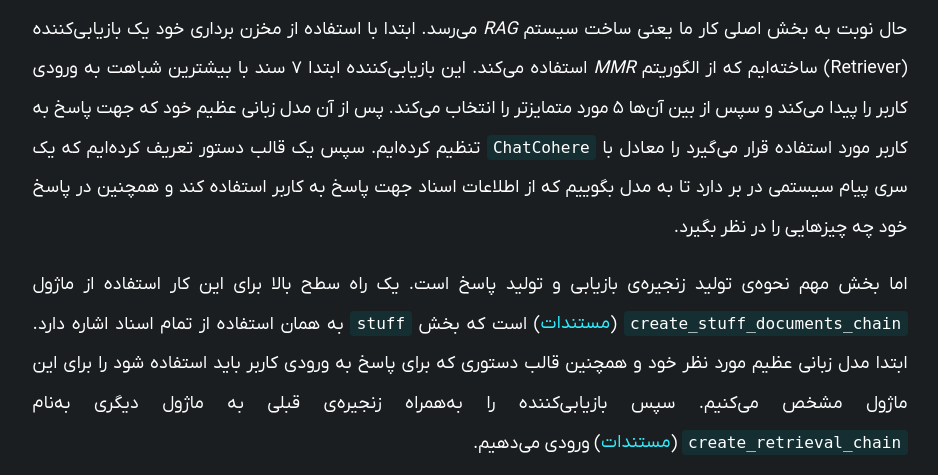

In [19]:
from langchain_cohere import ChatCohere
from langchain.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"fetch_k": 7, "k": 5})

llm = ChatCohere(cohere_api_key=cohere_api_key)

system_prompt = (
    "از محتوای بافتاری زیر برای پاسخ به سوال استفاده کن"
    "اگر پاسخ سوال را نمی‌دانی، بگو نمی‌دانم. "
    "پاسخ خود را مختصر و دقیق نگه دار و حداکثر در سه جمله بنویس."
    "بافتار: {context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
chain = create_retrieval_chain(retriever, question_answer_chain)

![Screenshot from 2025-04-01 16-49-22.png](<attachment:Screenshot from 2025-04-01 16-49-22.png>)
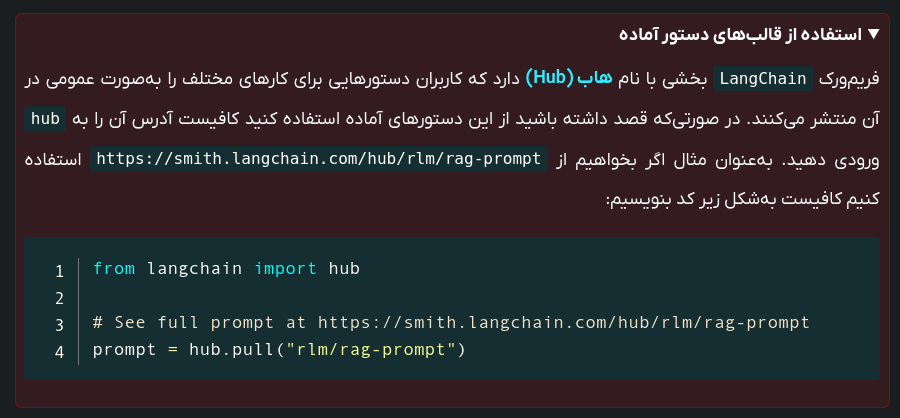

## Get response from RAG

In [20]:
query = "اپل چه تصمیمی درباره‌ی سانسور VPN گرفته است؟"
response = chain.invoke({"input": query})

In [22]:
response["context"]

[Document(metadata={'source': 'https://news.ycombinator.com/item?id=41284549', 'title': 'Apple might be implementing a VPN censorship order in Brazil'}, page_content="luuurker 7 months ago  \n             | root | parent | next [–] \n\n> The point is an iphone can be configured to use a VPN (operated by anybody, not limited to Apple) without requiring the use of appsA very specific type of VPN, which is easily blocked.I don't know if it's monopolistic as the comment you replied to says, but in the context of the thread, the build-in support doesn't fix the problem banning apps from the app store creates."),
 Document(metadata={'source': 'https://news.ycombinator.com/item?id=41284549', 'title': 'Apple might be implementing a VPN censorship order in Brazil'}, page_content='thiagoharry 7 months ago  \n             | prev | next [–] \n\nI am Brazilian and as far as I know, there is no previous case in Brazil where VPN services were removed from online stores or any other web page. Apple do

In [21]:
from IPython.display import display, HTML

md = "<p dir=rtl>{}</p>".format(response["answer"])

display(HTML(md))

In [23]:
query = "نظر کاربران درباره‌ی تصمیم اپل مبنی بر حذف اپلیکیشن‌های VPN از نظر آزادی چیست؟"
response = chain.invoke({"input": query})

In [24]:
response["context"]

[Document(metadata={'source': 'https://news.ycombinator.com/item?id=41284549', 'title': 'Apple might be implementing a VPN censorship order in Brazil'}, page_content="luuurker 7 months ago  \n             | next [–] \n\nThis is Apple blocking (some?) VPN apps from the App Store  because [edit: probably] they're required to do so, something they've been doing for a while in some countries (eg: China, Russia).And this is why I want to have the option to install whatever I want on my devices without needing to use the app store everyone uses. Not a very popular position among Apple users because everything must come only from the App Store for some reason, but when something like this happens, you have no alternatives."),
 Document(metadata={'source': 'https://news.ycombinator.com/item?id=41284549', 'title': 'Apple might be implementing a VPN censorship order in Brazil'}, page_content='bdw5204 7 months ago  \n             | root | parent | prev | next [–] \n\nGiving up freedom for "securi

In [25]:
from IPython.display import display, HTML

md = "<p dir=rtl>{}</p>".format(response["answer"])

display(HTML(md))

## Reranker

![Screenshot from 2025-04-01 17-03-04.png](<attachment:Screenshot from 2025-04-01 17-03-04.png>)
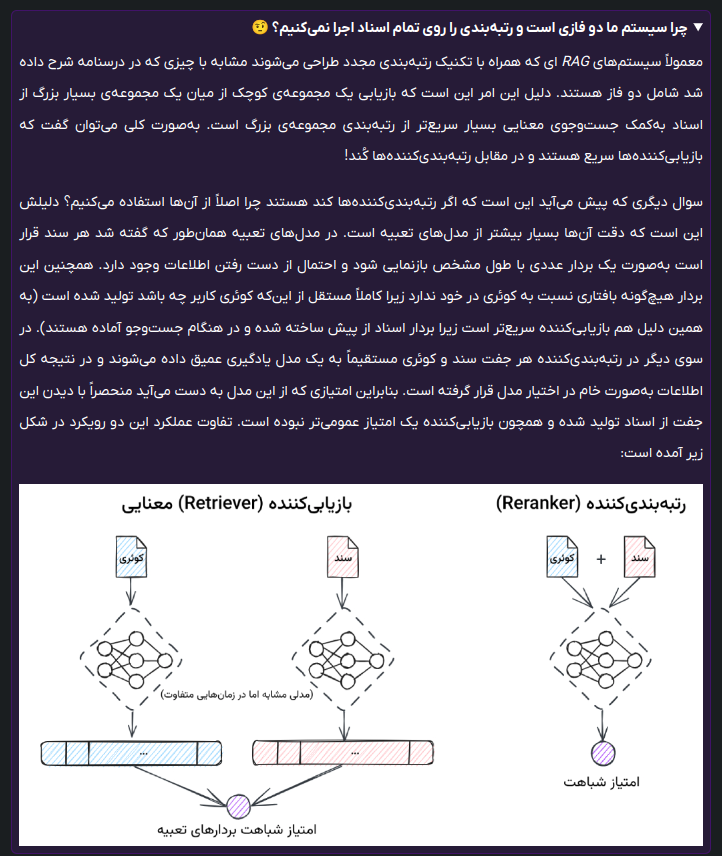